<a href="https://colab.research.google.com/github/riccardoorru/painting_genre_recognition/blob/main/5_CNN_balanced_with_dropout_on_100_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
from google.colab import drive
from google.colab import files
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
import pickle
seed(1)
tf.random.set_seed(1)

In [13]:

# mount drive
from google.colab import drive
drive.mount('RiccardoOrruProject', force_remount=True)

Mounted at RiccardoOrruProject


In [15]:
#I percorsi sono diversi in quanto la cartella è stata rinominata per la consegna
# [Deep Learning Project] = Orru
root_path = "RiccardoOrruProject/MyDrive/Deep Learning Project"
dataset_dir = os.path.join(root_path, "Dataset (1)")
train_dir = os.path.join(dataset_dir, 'train/genre')
test_dir = os.path.join(dataset_dir, 'val/genre')
balanced_train_dir = "RiccardoOrruProject/MyDrive/Deep Learning Project/Dataset (1)/balanced_train"
balanced_test_dir = "RiccardoOrruProject/MyDrive/Deep Learning Project/Dataset (1)/balanced_test"

In [10]:
#Set the parameter used to load the dataset
BATCH_SIZE = 64
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

In [11]:
ls


RiccardoOrruProject/  sample_data/


In [16]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    balanced_train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="training",
    shuffle=True,
    seed=1024)

validation_dataset = image_dataset_from_directory(
    balanced_train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="validation",
    shuffle=True,
    seed=1024)

test_dataset = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 6300 files belonging to 14 classes.
Using 5670 files for training.
Found 6300 files belonging to 14 classes.
Using 630 files for validation.
Found 1564 files belonging to 14 classes.


In [17]:


from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.regularizers import l2,l1_l2

classes = list(os.listdir(balanced_train_dir))

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, strides=1 , activation="relu", padding="same",kernel_regularizer=l2(0.01))(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=1, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=1, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=1, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(14, activation="softmax",kernel_regularizer=l1_l2(l1=0.02, l2=0.05))(x)
model = keras.Model(inputs=inputs, outputs=outputs)



In [18]:
dir_name = os.path.join(root_path, "Models")
if not os.path.exists(dir_name):
  os.makedirs(dir_name)


In [19]:

from tensorflow.keras import layers
from tensorflow.keras import optimizers

callbacks_list = [
keras.callbacks.EarlyStopping(
monitor='val_loss',
patience=10,
),
keras.callbacks.ModelCheckpoint(
filepath=os.path.join(dir_name, 'L2_model.h5'),
monitor='val_loss',
save_best_only=True,
),
keras.callbacks.ReduceLROnPlateau(
monitor='val_loss',
factor=0.1,
patience=5,
)
]


optimizer = keras.optimizers.Adam(learning_rate=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])




In [20]:


history = model.fit(train_dataset,
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_data=validation_dataset
                    )



Epoch 1/100
89/89 [==============================] - 750s 8s/step - loss: 6.3448 - accuracy: 0.1062 - val_loss: 2.7348 - val_accuracy: 0.1365 - lr: 0.0010
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


89/89 [==============================] - 31s 330ms/step - loss: 2.6362 - accuracy: 0.1501 - val_loss: 2.5541 - val_accuracy: 0.1698 - lr: 0.0010
Epoch 3/100
89/89 [==============================] - 31s 332ms/step - loss: 2.5447 - accuracy: 0.1536 - val_loss: 2.4798 - val_accuracy: 0.1603 - lr: 0.0010
Epoch 4/100
89/89 [==============================] - 30s 310ms/step - loss: 2.5093 - accuracy: 0.1647 - val_loss: 2.4763 - val_accuracy: 0.1730 - lr: 0.0010
Epoch 5/100
89/89 [==============================] - 31s 310ms/step - loss: 2.4889 - accuracy: 0.1730 - val_loss: 2.4464 - val_accuracy: 0.2190 - lr: 0.0010
Epoch 6/100
89/89 [==============================] - 30s 322ms/step - loss: 2.4586 - accuracy: 0.1917 - val_loss: 2.3922 - val_accuracy: 0.2048 - lr: 0.0010
Epoch 7/100
89/89 [==============================] - 32s 343ms/step - loss: 2.4140 - accuracy: 0.2145 - val_loss: 2.3621 - val_accuracy: 0.2286 - lr: 0.0010
Epoch 8/100
89/89 [==============================] - 29s 302ms/step - 

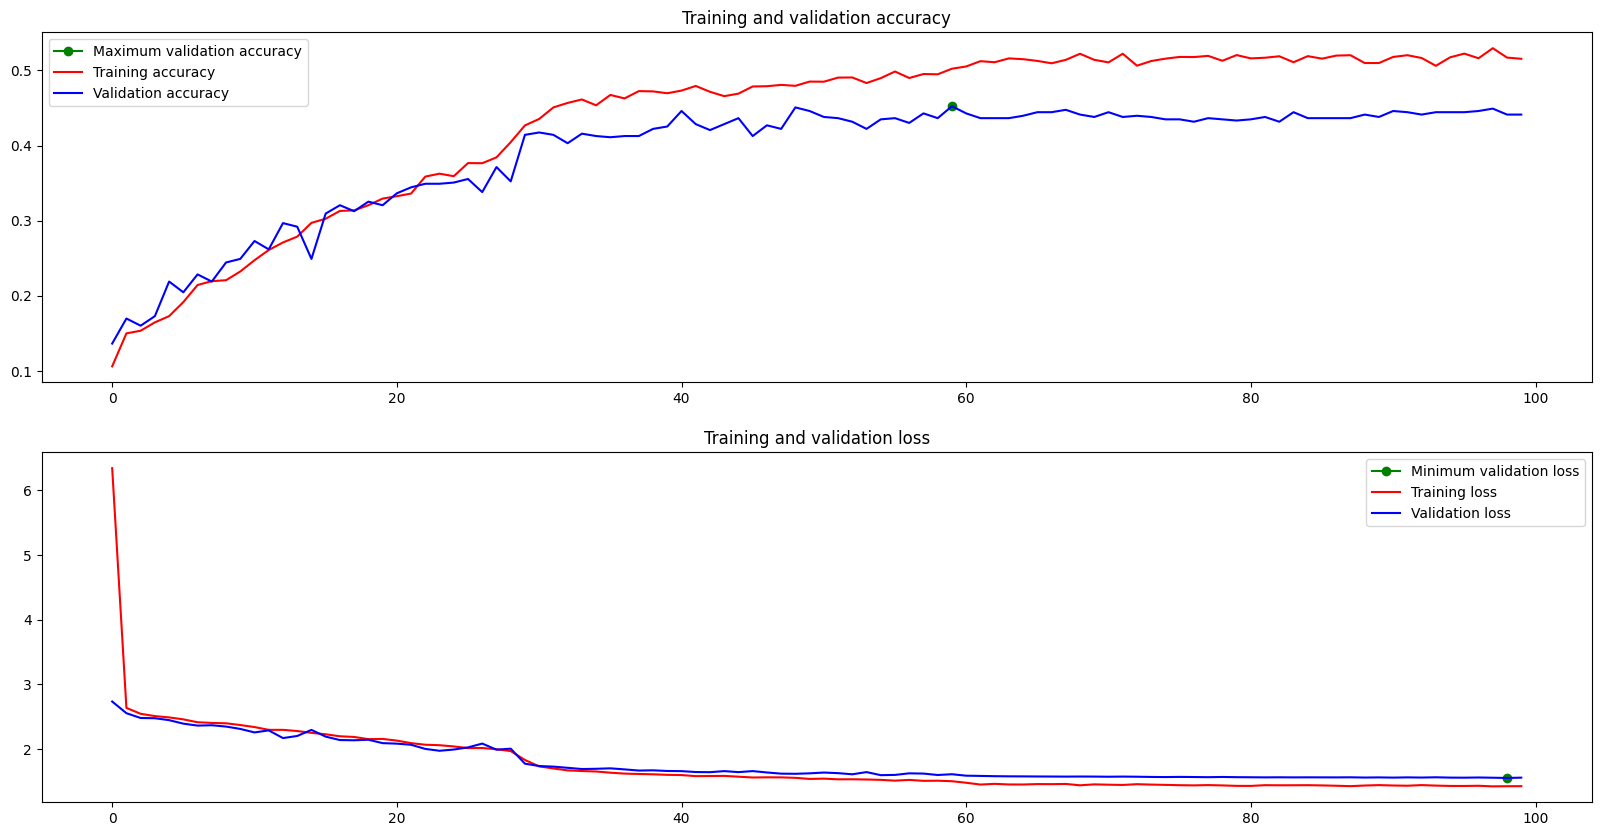

In [21]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

i_acc = np.argmax(val_acc)
x_min_acc = epochs[i_acc]
y_min_acc = val_acc[i_acc]
ax1.plot(x_min_acc, y_min_acc, 'g', marker='o', label="Maximum validation accuracy")

ax1.plot(epochs, acc, 'r', label='Training accuracy')
ax1.plot(epochs, val_acc, 'b', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend()

i_loss = np.argmin(val_loss)
x_min_loss = epochs[i_loss]
y_min_loss = val_loss[i_loss]
ax2.plot(x_min_loss, y_min_loss, 'g', marker='o', label="Minimum validation loss")

ax2.plot(epochs, loss, 'r', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()

plt.show()


In [22]:
test_loss, test_accuracy = model.evaluate(test_dataset)

25/25 [==============================] - 183s 5s/step - loss: 1.9281 - accuracy: 0.3363


In [27]:
print("Loss: " + str(test_loss))
print("Accuracy: " + str(test_accuracy))

history.history["test_loss"] = test_loss
history.history["test_accuracy"] = test_accuracy

Loss: 1.9281
Accuracy: 0.3363


In [24]:


dir_name = os.path.join(root_path, "Models")
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, 'cnnBalancedDS2.h5'))
with open(os.path.join(dir_name, 'trainHistory'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
